## scikit-learn digits dataset example

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target

In [5]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [6]:
y_cat = to_categorical(y)
y_cat

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### create model

In [7]:
'''
chose landmarks from sample
pick 20 landmarks data each digit
'''
np.random.seed(0)
num_lm0 = 10
num_lm = num_lm0 * 10
init_list = []
for ii in range(10):
    init_wgt0 = X_sc[y==ii]
    init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                np.random.normal(scale=0.01, size=num_lm0*64).reshape(num_lm0, 64)
    init_list.append(init_wgt0)
init_wgt = np.vstack(init_list)
init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
init_wgt.shape

(100, 64)

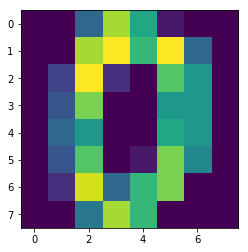

In [8]:
plt.imshow(X[0].reshape((8,8)))

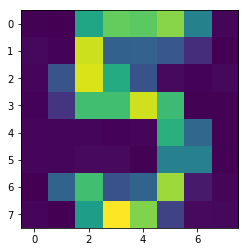

In [9]:
plt.imshow(init_wgt[0].reshape((8,8)))

In [10]:
np.random.seed(0)
num_lm2 = 20

def make_modelz():
    inp = Input(shape=(64,), name='inp')
    oup = inp
    
    oup_gk1 = GaussianKernel(num_lm, 64, kernel_gamma=1./(2.*64*0.1), weights=[init_wgt], name='gkernel1')(oup)
    model_gk1 = Model(inp, oup_gk1)
    
    oup_gk2 = GaussianKernel(num_lm2, num_lm, kernel_gamma=1./(2.*num_lm*0.1), name='gkernel2')(oup_gk1)
    model_gk2 = Model(inp, oup_gk2)
    
    oup = Dense(10, activation='softmax')(oup_gk2)
    
    model = Model(inp, oup)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return {
        'model': model,
        'model_gk1': model_gk1,
        'model_gk2': model_gk2,
    }

models = make_modelz()
model = models['model']
model.summary()

0.05
0.078125
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 64)                0         
_________________________________________________________________
gkernel1 (GaussianKernel)    (None, 100)               6400      
_________________________________________________________________
gkernel2 (GaussianKernel)    (None, 20)                2000      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 8,610
Trainable params: 8,610
Non-trainable params: 0
_________________________________________________________________


### train

In [11]:
model.fit(X_sc, y_cat, verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### predict

In [12]:
y_pred = model.predict(X_sc, batch_size=1024)
y_pred

array([[  9.16166365e-01,   7.53050990e-05,   3.79372032e-05, ...,
          4.13378766e-05,   4.89077670e-03,   2.51282137e-02],
       [  1.71454565e-04,   5.49643695e-01,   1.38191313e-01, ...,
          7.62402639e-02,   1.29118830e-01,   1.00598969e-02],
       [  1.70151878e-04,   4.66930330e-01,   2.65200257e-01, ...,
          1.44535955e-02,   1.46195710e-01,   7.45773269e-03],
       ..., 
       [  3.42366192e-03,   2.95904577e-01,   6.01300783e-02, ...,
          9.39614419e-03,   2.03184038e-01,   1.31994914e-02],
       [  1.52223557e-01,   1.54553819e-02,   1.08633637e-02, ...,
          4.51825513e-03,   1.82117790e-01,   3.10892642e-01],
       [  1.90245137e-02,   1.27319843e-01,   9.13201496e-02, ...,
          4.53756889e-03,   3.70398939e-01,   8.37366059e-02]], dtype=float32)

In [13]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[172,   0,   0,   0,   2,   2,   1,   0,   1,   0],
       [  0, 152,   9,   0,   6,   2,   4,   4,   5,   0],
       [  0,  12, 149,   8,   0,   0,   0,   1,   5,   2],
       [  0,   0,   4, 158,   0,   0,   0,   5,   8,   8],
       [  0,   1,   0,   0, 175,   1,   1,   3,   0,   0],
       [  4,   0,   0,   0,   1, 139,   0,  10,   2,  26],
       [  3,   2,   0,   0,   1,   0, 175,   0,   0,   0],
       [  0,   1,   0,   0,   0,   6,   0, 172,   0,   0],
       [  0,  26,   6,   4,   1,  16,   1,   0, 109,  11],
       [  0,   0,   0,  10,   1,  26,   0,  13,   5, 125]])

In [14]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96       178
          1       0.78      0.84      0.81       182
          2       0.89      0.84      0.86       177
          3       0.88      0.86      0.87       183
          4       0.94      0.97      0.95       181
          5       0.72      0.76      0.74       182
          6       0.96      0.97      0.96       181
          7       0.83      0.96      0.89       179
          8       0.81      0.63      0.71       174
          9       0.73      0.69      0.71       180

avg / total       0.85      0.85      0.85      1797



### plot output of GaussianKernel layer #1

In [15]:
lm2 = model.get_layer('gkernel2').get_weights()[0]
lm2.shape

(20, 100)

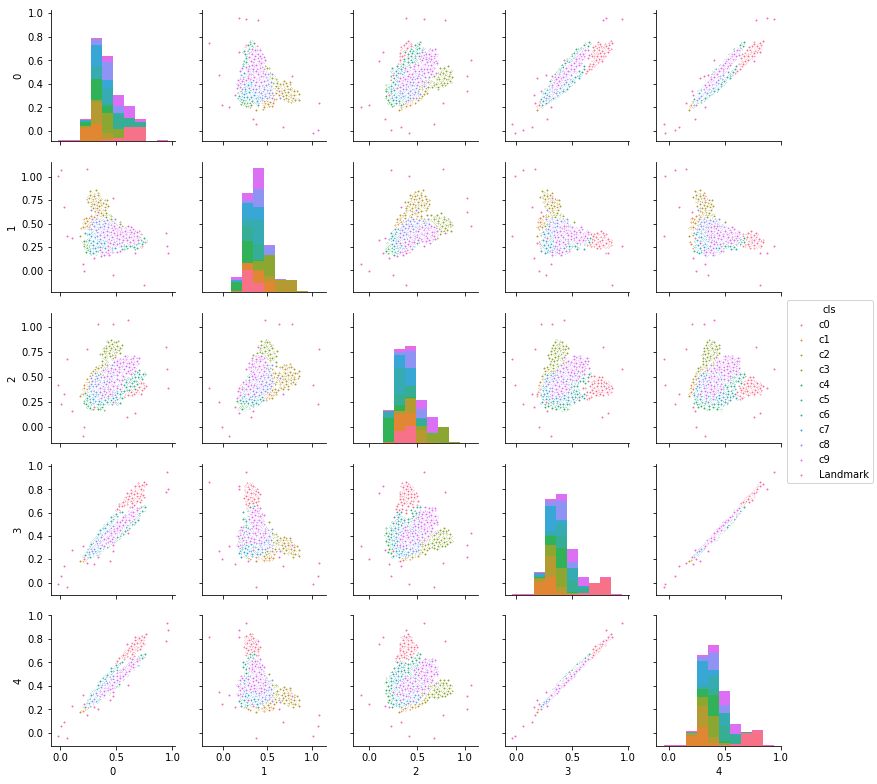

In [16]:
gk1_pred = models['model_gk1'].predict(X_sc, batch_size=1024)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

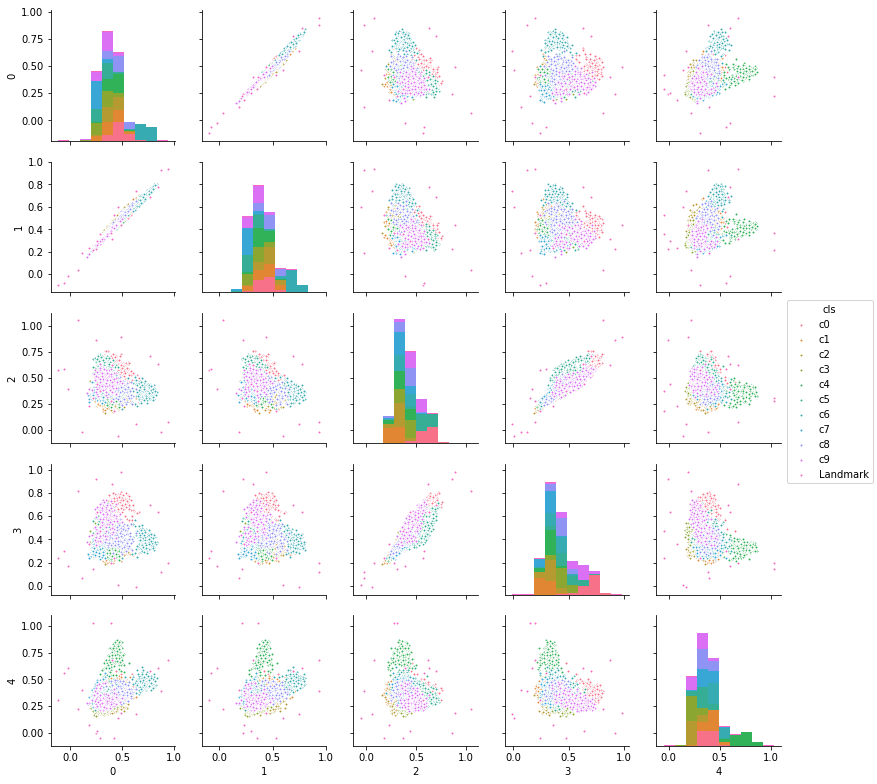

In [17]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of GaussianKernel layer #2

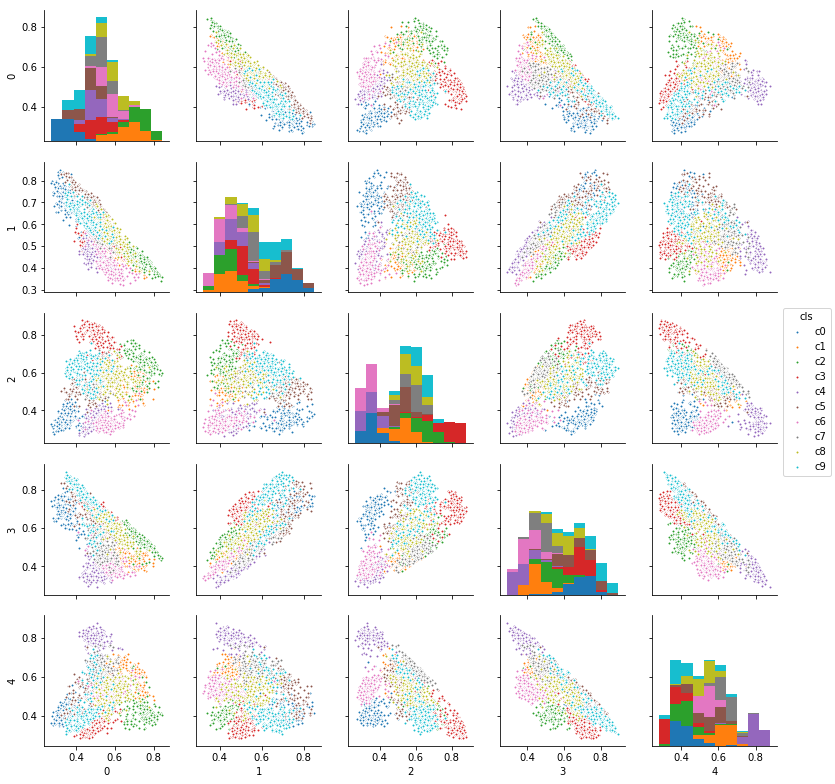

In [18]:
gk2_pred = models['model_gk2'].predict(X_sc)
df = pd.DataFrame(gk2_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

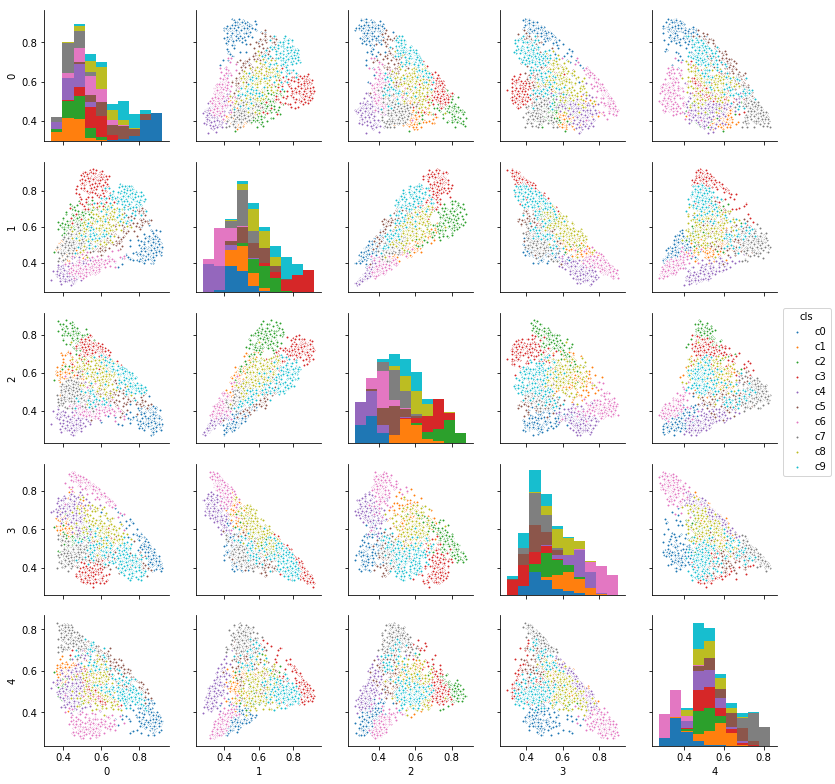

In [19]:
df = pd.DataFrame(gk2_pred[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### train more

In [20]:
model.fit(X_sc, y_cat, verbose=0,
          batch_size=32,
          epochs=1500)

### predict

In [21]:
y_pred = model.predict(X_sc, batch_size=1024)
y_pred

array([[  9.99106467e-01,   6.75956846e-09,   9.91407276e-08, ...,
          3.83850931e-07,   2.94758007e-04,   3.92594899e-04],
       [  3.83755861e-07,   9.90667164e-01,   6.22020219e-04, ...,
          3.70638270e-04,   4.96370578e-03,   9.89018881e-05],
       [  1.21911194e-06,   5.13730347e-02,   9.25258040e-01, ...,
          3.60078193e-05,   2.23986506e-02,   2.34343884e-06],
       ..., 
       [  1.16964325e-03,   9.09190550e-02,   1.46522815e-03, ...,
          9.10682284e-05,   6.52047455e-01,   4.02055302e-04],
       [  2.06732955e-02,   3.75053263e-04,   1.37041716e-05, ...,
          9.31772593e-05,   5.49750514e-02,   9.19515729e-01],
       [  6.11155713e-03,   5.55532007e-03,   1.11185689e-03, ...,
          2.17527977e-05,   9.01112735e-01,   5.76389860e-03]], dtype=float32)

In [22]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[176,   0,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0, 181,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   1, 176,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2, 177,   0,   3,   0,   0,   1,   0],
       [  0,   4,   0,   0, 176,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0, 180,   0,   0,   0,   2],
       [  1,   1,   0,   0,   0,   0, 179,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0, 177,   0,   1],
       [  0,   4,   1,   1,   0,   2,   0,   0, 166,   0],
       [  0,   0,   0,   3,   1,   2,   0,   0,   1, 173]])

In [23]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       178
          1       0.95      0.99      0.97       182
          2       0.98      0.99      0.99       177
          3       0.98      0.97      0.97       183
          4       0.98      0.97      0.98       181
          5       0.96      0.99      0.98       182
          6       0.99      0.99      0.99       181
          7       0.99      0.99      0.99       179
          8       0.98      0.95      0.97       174
          9       0.98      0.96      0.97       180

avg / total       0.98      0.98      0.98      1797



### plot output of GaussianKernel layer #1

In [24]:
lm2 = model.get_layer('gkernel2').get_weights()[0]
lm2.shape

(20, 100)

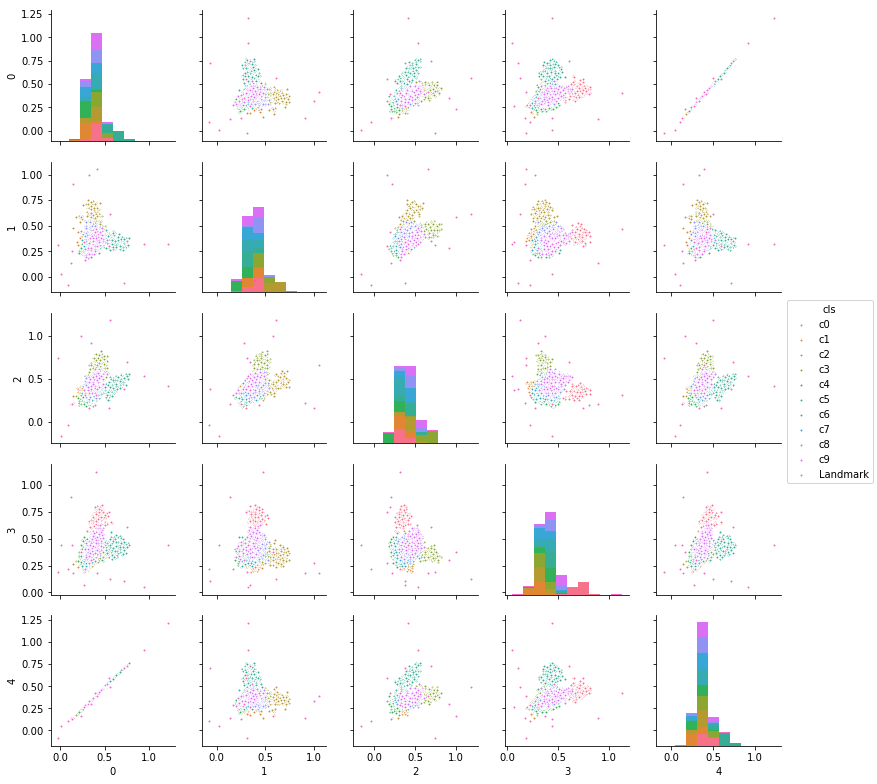

In [25]:
gk1_pred = models['model_gk1'].predict(X_sc, batch_size=1024)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,:5])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

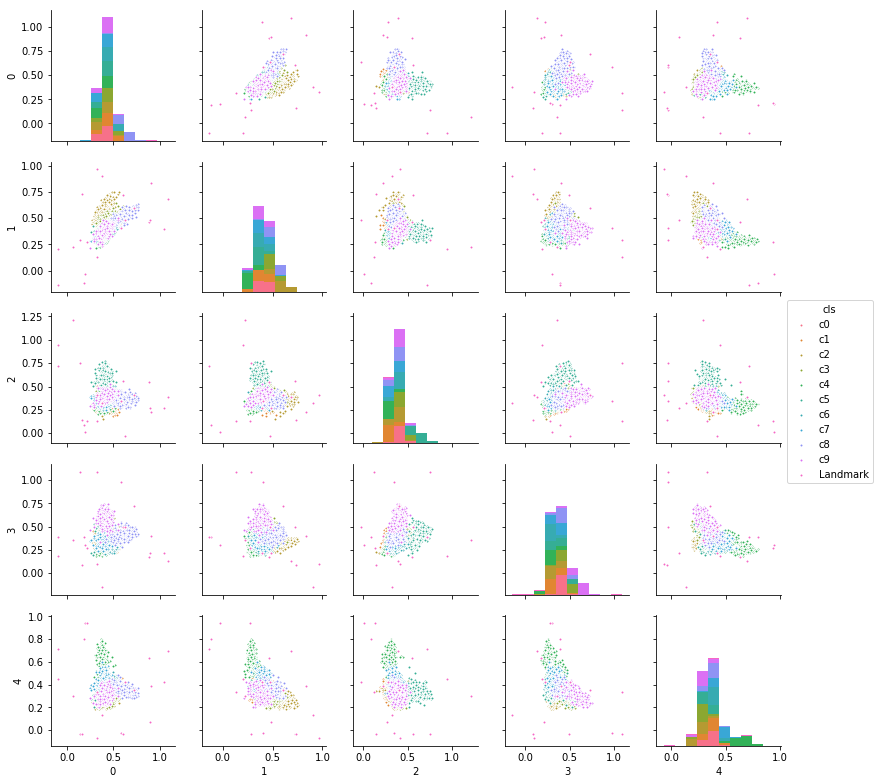

In [26]:
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark'] * lm2.shape[0]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of GaussianKernel layer #2

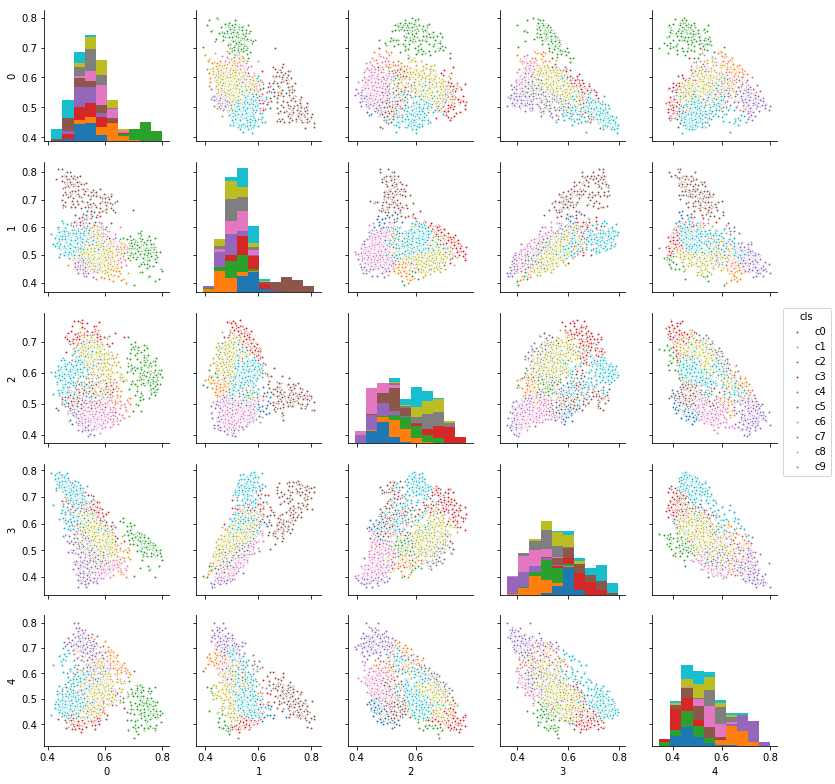

In [27]:
gk2_pred = models['model_gk2'].predict(X_sc)
df = pd.DataFrame(gk2_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

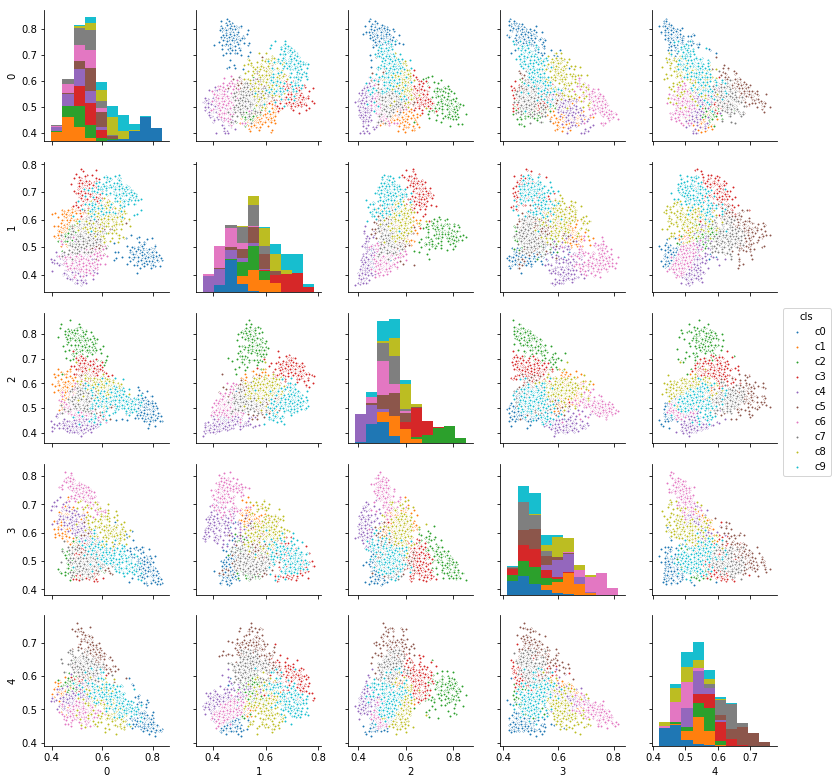

In [28]:
df = pd.DataFrame(gk2_pred[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)